In [36]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy import integrate, optimize

## Problem 1

In [2]:
# Define black hole masses (in grams)
EBH_mass_arr = [2.5*1e11, 4*1e11, 9*1e11]

# Load simualted neutrino data
sim_energies = np.genfromtxt('neutrino_energies.csv', delimiter = ',', skip_header = 1)

## Problem 1A

Make a few helper functions

In [3]:
# Define function that converts the mass of black hole to temperature (in GeV)
def EBH_temperature(mass):
    return (1.057 * 1e13) / mass

# Define a function that returns the normalised PDF for neutrinos (nummerical integrations)
def PDF_norm(energies, mass, up_lim):
    
    # First we get the temperature of the black hole
    temp = EBH_temperature(mass)
    
    # Define func to integrate
    function = lambda E: ( ( np.exp(E/temp)-1 )/( np.exp(E/temp)+3 ) ) * (1/( np.exp(E/temp)+1 ))
    
    # Integrate
    area, area_err = integrate.quad(function, 0, up_lim)
    
    # Find norm constant
    k = 1 / area
    
    # Return normalised func, evaluated at energies
    return function(energies)*k

Lets use the function to plot the normalised PDF for the three masses

In [4]:
# Define energies to look at
energies_arr = np.linspace(0,300,1000)

# Define an empty list to store the PDF's in
PDF_list = []

# Loop over BH masses
for i in range(len(EBH_mass_arr)):
    
    # Calculate the PDF
    PDF_list.append( PDF_norm(energies_arr, EBH_mass_arr[i], up_lim=500) )

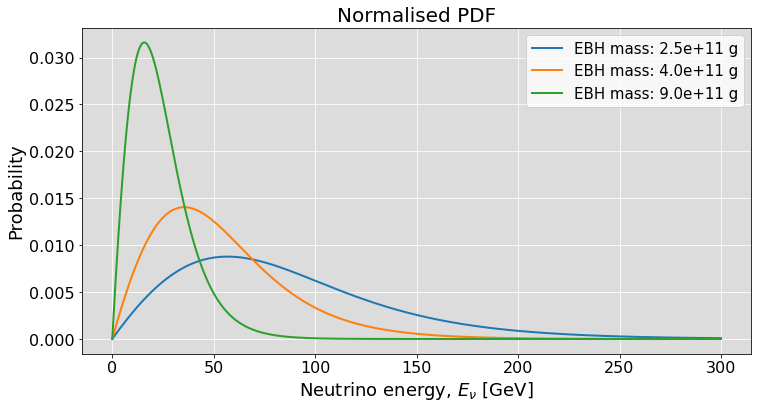

In [5]:
# Plot it
fig, ax = plt.subplots(figsize=(12,6))

for i in range(3):
    ax.plot(energies_arr, PDF_list[i], linewidth=2, label=f'EBH mass: {EBH_mass_arr[i]:.1e} g')

ax.set_title('Normalised PDF', fontsize=20)
ax.set_xlabel('Neutrino energy, $E_ν$ [GeV]', fontsize=18)
ax.set_ylabel('Probability', fontsize=18) 
    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_facecolor('gainsboro')
ax.grid(color='white')
ax.legend(prop={'size':15})
plt.show()

## Problem 1B

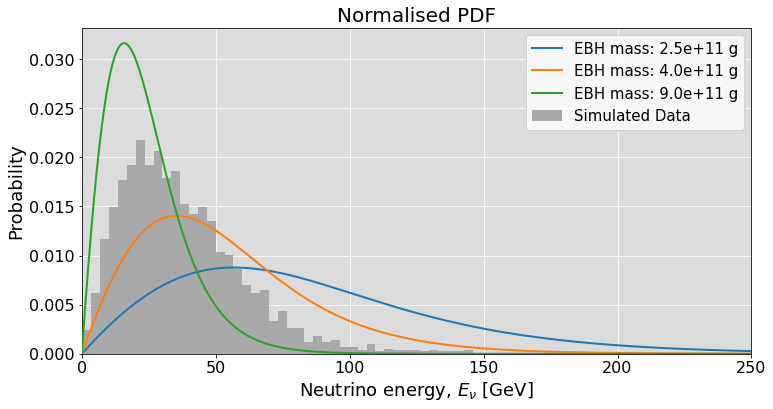

In [6]:
# Plot it
fig, ax = plt.subplots(figsize=(12,6))

# Plot PDF's
for i in range(3):
    ax.plot(energies_arr, PDF_list[i], linewidth=2, label=f'EBH mass: {EBH_mass_arr[i]:.1e} g',zorder=3)

# Plot neutrino data, density=True normalises the histogrma
ax.hist(sim_energies, density=True, bins=50, color='darkgrey',zorder=2, label='Simulated Data')

ax.set_title('Normalised PDF', fontsize=20)
ax.set_xlabel('Neutrino energy, $E_ν$ [GeV]', fontsize=18)
ax.set_ylabel('Probability', fontsize=18) 

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_facecolor('gainsboro')
ax.grid(color='white')
ax.legend(prop={'size':15})
plt.xlim(0,250)
plt.show()

The energy will be somewhere between the orange and the green graph. Im not completely sure how it scales but around 6-7 1e11 g.

## Problem 1C

In [12]:
# Define ln-likelihood function
def ln_likelihood(mass, data):
    
    # Calc PDF from mass
    PDF = PDF_norm(data, mass, up_lim=500)
    
    # Return log likelihood
    return np.sum( np.log(PDF) ) 

In [43]:
# Define number of points to check
N_test = 1000

# Define temperatures to check in the scan
mass_scan = np.linspace(4,9,N_test)*1e11

# Array to store llh in
llh_arr = np.zeros(N_test)

# Calc log likelihoods
for i in range(N_test):
    
    # Calc log likelihood
    llh_arr[i] = ln_likelihood(mass_scan[i], sim_energies)
    
# Mark the best result
best_idx = np.argmax(llh_arr)
best_mass = mass_scan[best_idx]
best_llh = llh_arr[best_idx]
print(f'{best_mass:.10e}', best_llh)

5.7467467467e+11 -11252.798562014359


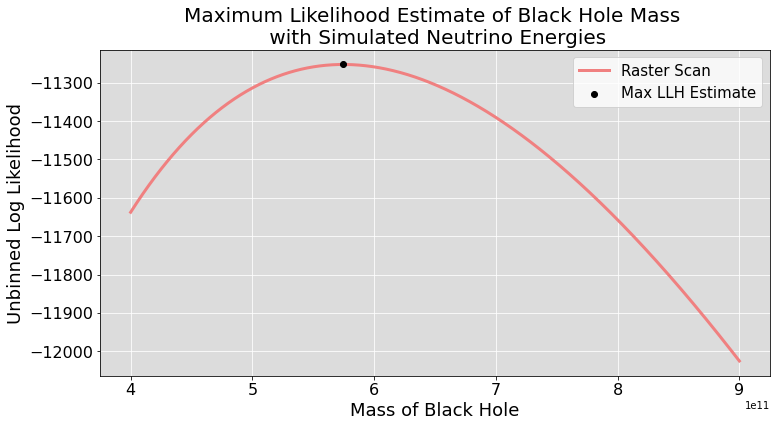

In [33]:
# Plot results
fig, ax = plt.subplots(figsize=(12,6))

# Plot scan
ax.plot(mass_scan, llh_arr, linewidth=3, color='lightcoral', zorder=2, label='Raster Scan')

# MArk best val
ax.scatter(best_mass, best_llh, color='k', zorder=3, label='Max LLH Estimate')

ax.set_title('Maximum Likelihood Estimate of Black Hole Mass \n with Simulated Neutrino Energies', fontsize=20)
ax.set_xlabel('Mass of Black Hole', fontsize=18)
ax.set_ylabel('Unbinned Log Likelihood', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_facecolor('gainsboro')
ax.grid(color='white')
ax.legend(prop={'size':15})

plt.show()

In [35]:
# Values of LLH at the three proposed BH masses from 1B
for i in range(3):
    print(f'For BH mass {EBH_mass_arr[i]:.1e} the LLH is {ln_likelihood(EBH_mass_arr[i], sim_energies):.0f}' )

For BH mass 2.5e+11 the LLH is -12979
For BH mass 4.0e+11 the LLH is -11638
For BH mass 9.0e+11 the LLH is -12025


## Problem 1D

In [66]:
# Define the negative ln_likelihood
def neg_llh(mass):
    
    # Convert mass to g
    mass = mass.copy()
    
    # Calc PDF from mass
    PDF = PDF_norm(sim_energies, mass, up_lim=500)
    
    # Return - log likelihood
    return - np.sum( np.log(PDF) ) 

In [67]:
# Minimize with scipy
sol = optimize.minimize(fun=neg_llh, x0=best_mass, options={'maxiter':1e6})

# Get result
sol.x, neg_llh(sol.x)

(array([5.74674675e+11]), 11252.798562014359)

Problems with the large numbers and it just returns the initial guess.

In [74]:
# Define the negative ln_likelihood
def neg_llh(mass):
    
    # Convert mass to g
    mass = mass.copy() * 1e11
    
    # Calc PDF from mass
    PDF = PDF_norm(sim_energies, mass, up_lim=500)
    
    # Return - log likelihood
    return - np.sum( np.log(PDF) ) 

# Minimize with scipy
sol = optimize.minimize(fun=neg_llh, x0=20, bounds=np.array([[0.1,10000]]), options={'maxiter':1e6})

# Get result
sol.x, neg_llh(sol.x)

(array([5.74586382]), 11252.798483865)